In [1]:
import tensorflow 
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
from matplotlib.image import imread

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

import sys
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from IPython.display import display
from PIL import Image

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import random 
from tensorflow.keras import models
from tensorflow.keras import backend as K

import pandas as pd

from tensorflow.keras.applications import VGG16, Xception, ResNet50, ResNet101, InceptionResNetV2, DenseNet201

In [2]:
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128

In [4]:
#Write the local Data and Model Path
DATA_PATH = 'C:\\Users\\pacol\\Desktop\\GIT\\COVID19\\data\\'
MODEL_PATH = 'C:\\Users\\pacol\\Desktop\\GIT\\COVID19\\data\\'

# Data Generator

In [5]:
def data_generator(batch_size):
    train_datagen = ImageDataGenerator(rescale = 1./255)
    val_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen = ImageDataGenerator(rescale = 1./255)

    BATCH_SIZE = batch_size
    IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

    train_dir = DATA_PATH + 'Sorted Data\\train'
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        shuffle = True,
        class_mode = 'categorical'
    )

    test_dir = DATA_PATH + 'Sorted Data\\test'
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        shuffle = True,
        class_mode = 'categorical'
    )

    val_dir = DATA_PATH + 'Sorted Data\\val'
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        shuffle = True,
        class_mode = 'categorical'
    )
    return train_generator, test_generator, val_generator


# Create CNN

In [6]:
def build_model(model_name):


    if model_name == 'DenseNet201':

        conv_base6 = DenseNet201(include_top=False, weights=None, input_tensor=None, input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3), pooling=None, classes=3)

        modelDenseNet201 = Sequential()
        modelDenseNet201.add(conv_base6)

        modelDenseNet201.add(Flatten())
        modelDenseNet201.add(Dense(512, activation='relu'))
        modelDenseNet201.add(BatchNormalization())
        modelDenseNet201.add(Dropout(0.5))
        modelDenseNet201.add(Dense(3, activation='softmax')) 
        return modelDenseNet201

In [7]:
def model_evaluate(model_name,optimizer,epochs,batch_size, loss = 'categorical_crossentropy', plot=True):    

    train_generator, test_generator, val_generator = data_generator(batch_size)



    model = build_model(model_name)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    model.summary()

    os.chdir(MODEL_PATH)

    checkpoint = ModelCheckpoint('model_{}_epochs_{}_optimizer_SGD_batch_{}.h5'.format(model_name,epochs,batch_size), 
                                 monitor='val_accuracy', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 save_weights_only=False, 
                                 mode='auto', 
                                 period=1)

    callbacks_list = [checkpoint]

    hist=model.fit(train_generator,
                            epochs=epochs,
                            verbose=1,
                            shuffle=True,
                            steps_per_epoch = 2560 / batch_size,
                            validation_data = val_generator,
                            callbacks=callbacks_list)
    if(plot):
        print("------------Epochs: {}------------".format(epochs))
        #Visualize the models accuracy
        plt.plot(hist.history['accuracy'])
        plt.plot(hist.history['val_accuracy'])
        plt.title('Accuracy {}'.format(model.name))
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc='upper left')
        plt.show()

        #Visualize the models loss
        plt.plot(hist.history['loss'])
        plt.plot(hist.history['val_loss'])
        plt.title('Loss {}'.format(model.name))
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc='upper left')
        plt.show()
    

    loss_train = hist.history['loss'][-1]
    acc_train = hist.history['accuracy'][-1]
    loss_val = hist.history['val_loss'][-1]
    acc_val = hist.history['val_accuracy'][-1]

    print("Loss-> Train Set:{:.2f}; Val Set:{:.2f} (Diff: {:2f})".format(loss_train,loss_val,abs(loss_train-loss_val)))
    print("Accuracy-> Train Set:{:.2f}; Val Set:{:.2f} (Diff: {:2f})".format(acc_train,acc_val,abs(acc_train-acc_val)))
    
    predict = model.evaluate_generator(test_generator)
    
    
    return loss_train, acc_train, loss_val, acc_val, predict[0], predict[1]
    

In [8]:
opt=tensorflow.keras.optimizers.SGD(learning_rate=0.003, momentum=0.9)
epoch = 20
batch_size = 32

In [9]:
results = pd.DataFrame(columns=['Model','Optimizer','epochs','batch_sizes','loss_train', 'acc_train', 'loss_val', 'acc_val'])
results_test = pd.DataFrame(columns=['Model', 'Loss','Accuracy'])

# DenseNet201

Found 2560 images belonging to 3 classes.
Found 800 images belonging to 3 classes.
Found 640 images belonging to 3 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 4, 4, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 30720)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               15729152  
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539     

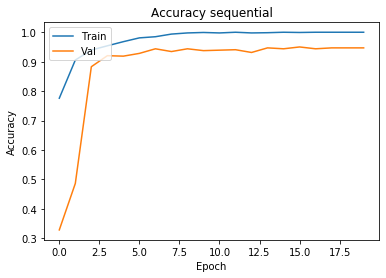

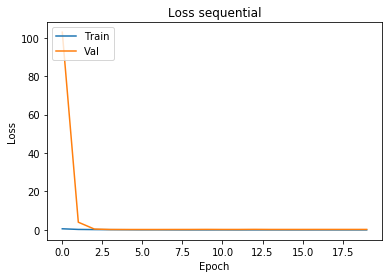

Loss-> Train Set:0.00; Val Set:0.25 (Diff: 0.252815)
Accuracy-> Train Set:1.00; Val Set:0.95 (Diff: 0.053125)


In [10]:
model_name = 'DenseNet201'
loss_train, acc_train, loss_val, acc_val, loss_test, acc_test = model_evaluate(model_name=model_name,optimizer=opt,epochs=epoch,batch_size=batch_size, plot=True)
results = results.append({'Model':model_name,'Optimizer':'SGD','epochs':epoch,'batch_sizes':batch_size,'loss_train':loss_train, 'acc_train':acc_train, 'loss_val':loss_val, 'acc_val':acc_val},ignore_index=True)
results_test = results_test.append({'Model':model_name,'Loss':loss_test,'Accuracy':acc_test},ignore_index=True)


In [11]:
results

,Model,Optimizer,epochs,batch_sizes,loss_train,acc_train,loss_val,acc_val
0,DenseNet201,SGD,20,32,0.000292,1.0,0.253108,0.946875


In [12]:
results_test

,Model,Loss,Accuracy
0,DenseNet201,0.198681,0.9525
